In [1]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.nn import TransformerEncoderLayer, TransformerEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [3]:
df = pd.read_csv('all_stock_data.csv')

### Understanding the Data

In [4]:
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,ED,0.0,0.265828,0.261788,0.261788,25600.0,0.0,0.0
1,1962-01-02,CVX,0.0,0.046809,0.046069,0.046809,105840.0,0.0,0.0
2,1962-01-02,GD,0.0,0.210033,0.203061,0.208290,2648000.0,0.0,0.0
3,1962-01-02,BP,0.0,0.141439,0.139528,0.139528,77440.0,0.0,0.0
4,1962-01-02,MSI,0.0,0.764923,0.745254,0.751810,65671.0,0.0,0.0


In [5]:
df.tail()

,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits
34646253,2024-11-04,NEOG,14.490000,14.580000,14.340000,14.345000,18972.0,0.0,0.0
34646254,2024-11-04,ENLV,1.400000,1.428900,1.330000,1.350000,28794.0,0.0,0.0
34646255,2024-11-04,FAMI,0.320000,0.320000,0.300100,0.300100,77650.0,0.0,0.0
34646256,2024-11-04,NNN,43.730000,43.439999,43.209999,43.244999,88675.0,0.0,0.0
34646257,2024-11-04,SHOO,44.740002,45.150002,44.724998,45.000000,26010.0,0.0,0.0


In [6]:
df.shape

(34646258, 9)

In [7]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3.464615e+07,3.464615e+07,3.464615e+07,3.464615e+07,3.464626e+07,3.464626e+07,34646258.0
mean,1.115049e+23,1.115049e+23,1.115049e+23,1.115049e+23,1.339230e+06,3.980156e-03,inf
std,3.954735e+25,3.954735e+25,3.954735e+25,3.954735e+25,1.567170e+07,1.603516e+00,NaN
min,-8.210044e+25,-8.210044e+25,-8.210044e+25,-8.210044e+25,0.000000e+00,0.000000e+00,0.0
25%,3.150000e+00,3.400000e+00,3.262533e+00,3.331568e+00,2.680000e+03,0.000000e+00,0.0
50%,1.088000e+01,1.112991e+01,1.082000e+01,1.098039e+01,5.380000e+04,0.000000e+00,0.0
75%,2.802786e+01,2.867335e+01,2.779270e+01,2.822554e+01,4.270000e+05,0.000000e+00,0.0
max,1.507290e+28,1.507290e+28,1.507290e+28,1.507290e+28,9.230856e+09,4.500000e+03,inf


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34646258 entries, 0 to 34646257
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Date          object 
 1   Ticker        object 
 2   Open          float64
 3   High          float64
 4   Low           float64
 5   Close         float64
 6   Volume        float64
 7   Dividends     float64
 8   Stock Splits  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ GB


In [9]:
df.isnull().mean()

Date            0.000000
Ticker          0.000000
Open            0.000003
High            0.000003
Low             0.000003
Close           0.000003
Volume          0.000000
Dividends       0.000000
Stock Splits    0.000000
dtype: float64

In [10]:
df.nunique()

Date               15819
Ticker              9315
Open            14065844
High            14044360
Low             14037087
Close            9835345
Volume           1745891
Dividends          11926
Stock Splits         466
dtype: int64

### Data Cleaning

In [11]:
df.dropna(inplace=True)

In [12]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [13]:
df.isnull().sum()

Date      0
Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

### Convert date to datetime datatype

In [14]:
df['Date'] = pd.to_datetime(df['Date'])

### Feature Generation

On-Balance Volume is a momentum indicator that relates volume to price changes:

Rising OBV → Indicates strong buying pressure. <br>
Falling OBV → Indicates selling pressure.

In [15]:
df['OBV'] = (df['Volume'] * (df['Close'].diff() > 0).astype(int) -
             df['Volume'] * (df['Close'].diff() < 0).astype(int)).cumsum()

The SMA is a common technical indicator in stock analysis, used to identify trends in stock prices.

In [16]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()  # 50-day moving average
df['SMA_200'] = df['Close'].rolling(window=200).mean()  # 200-day moving average

The Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements. It is used to assess whether a stock or other asset is overbought or oversold, which can help traders identify potential reversal points.

In [17]:
def rsi(df, period=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = rsi(df)

Calculating upper and lower bands for plotting Bollinger Band

In [18]:
df['Rolling_Mean'] = df['Close'].rolling(window=20).mean()  # 20-day moving average
df['Rolling_Std'] = df['Close'].rolling(window=20).std()  # Rolling standard deviation
df['Upper_Band'] = df['Rolling_Mean'] + (df['Rolling_Std'] * 2)
df['Lower_Band'] = df['Rolling_Mean'] - (df['Rolling_Std'] * 2)

Creating 'Trend' categorical feature 

In [19]:
# Bullish/Bearish classification
df['Trend'] = 'Sideways'
df.loc[(df['SMA_50'] > df['SMA_200']) & (df['RSI'] > 50), 'Trend'] = 'Bullish'
df.loc[(df['SMA_50'] < df['SMA_200']) & (df['RSI'] < 50), 'Trend'] = 'Bearish'

In [20]:
model_df = df

Drop null values created while generating new features

In [21]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)

### Split data into decades

In [22]:
# Extract the year from the 'Date' column
df['Year'] = df['Date'].dt.year

# Find the minimum and maximum years in the data
min_year = df['Year'].min()
max_year = df['Year'].max()

# Generate decades dynamically based on the available data
decade_start = (min_year // 10) * 10
decades = range(decade_start, max_year + 1, 10)

# Create a dictionary to store dataframes for each decade
decade_dataframes = {}

for decade in decades:
    # Filter data for the current decade
    start_year = decade
    end_year = decade + 9
    decade_label = f"{start_year}s"

    # Filter rows for the current decade
    decade_df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]

    # Only add to the dictionary if there's data for the decade
    if not decade_df.empty:
        decade_dataframes[decade_label] = decade_df

In [23]:
decade_dataframes.keys()

dict_keys(['1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s'])

In [24]:
for k,v in decade_dataframes.items():
    print(k,v.shape)

1960s (60200, 17)
1970s (349811, 17)
1980s (1626955, 17)
1990s (3512756, 17)
2000s (7025265, 17)
2010s (12344144, 17)
2020s (9726819, 17)


### Data Visualization

In [25]:
df_60 = decade_dataframes['1960s']
df_70 = decade_dataframes['1970s']
df_80 = decade_dataframes['1980s']
df_90 = decade_dataframes['1990s']
df_00 = decade_dataframes['2000s']
df_10 = decade_dataframes['2010s']
df_11 = decade_dataframes['2020s']
dataframes = [df_60, df_70, df_80, df_90, df_00, df_10, df_11]

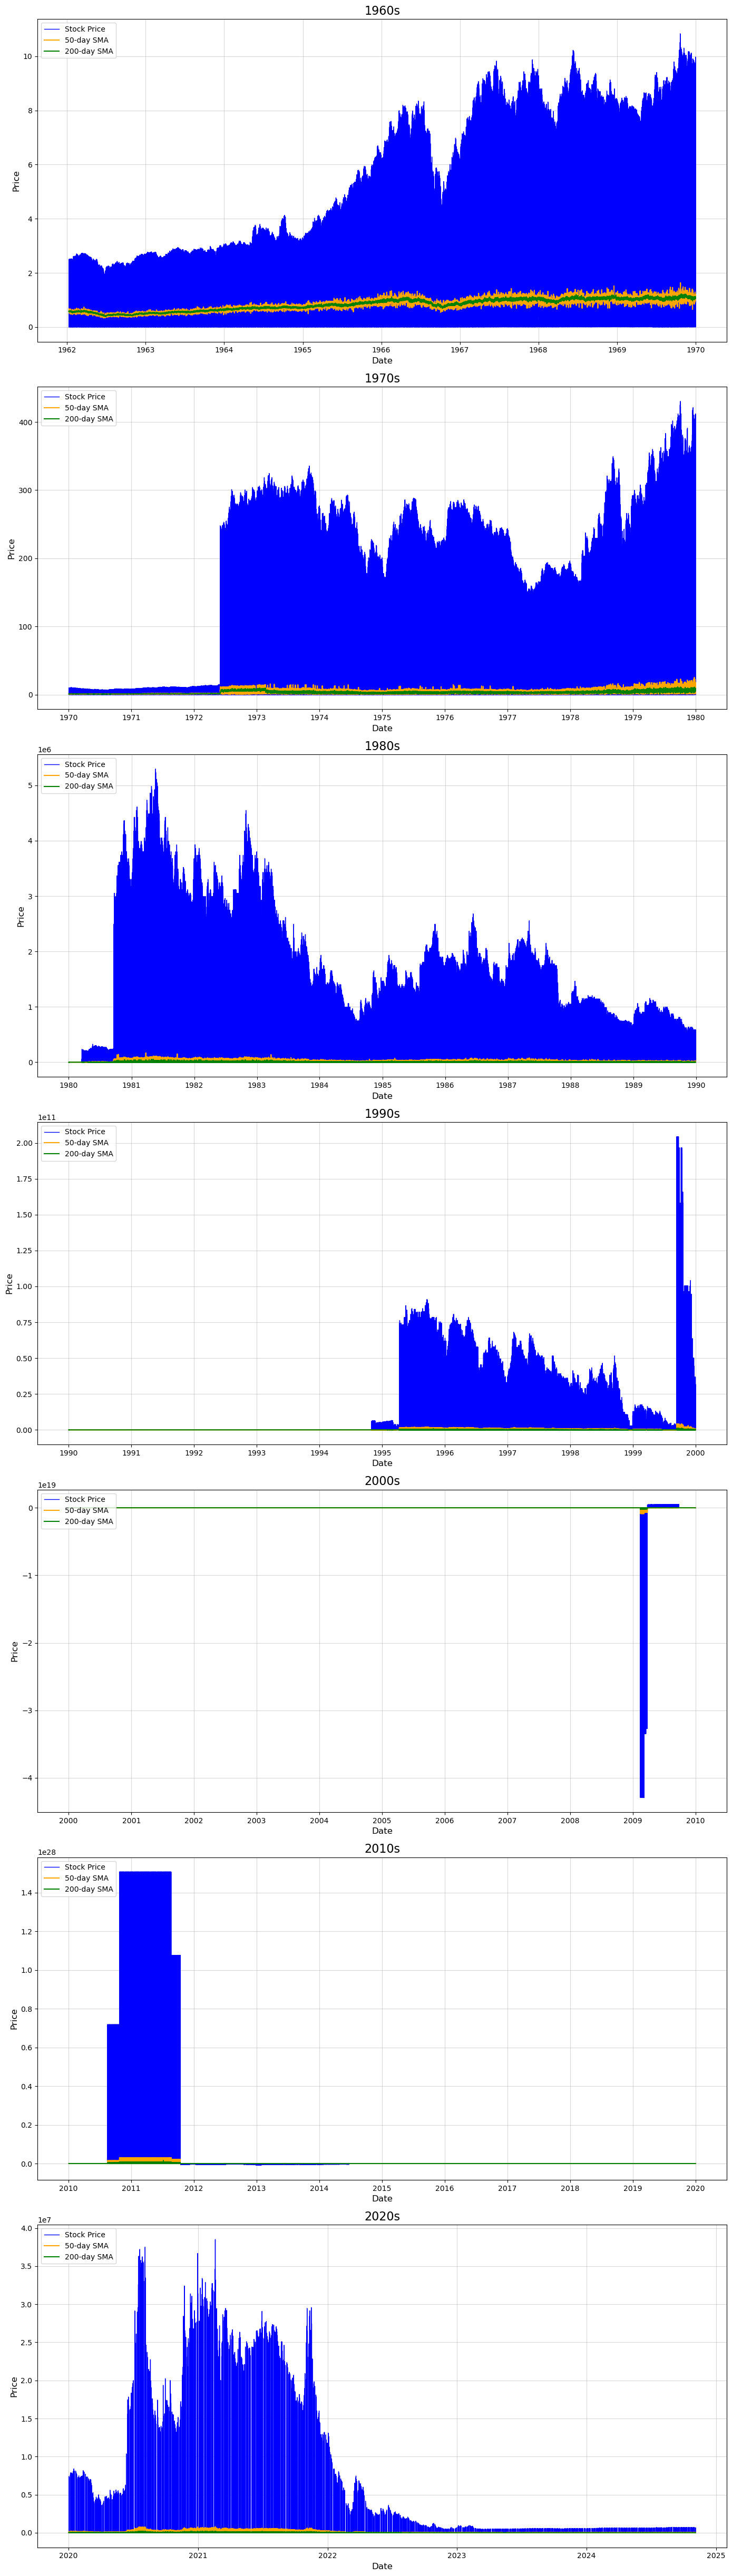

In [ ]:
n = len(dataframes)

# Set up the figure and subplots
plt.figure(figsize=(14, 7 * n))  # Adjust height to accommodate all plots

# Iterate over the dataframes and plot
for i, df in enumerate(dataframes):
    # Add a subplot for each dataframe
    plt.subplot(n, 1, i + 1)
    
    # Plot the stock price
    plt.plot(df['Date'], df['Close'], label='Stock Price', color='blue', linewidth=1)
    
    # Plot the 50-day SMA
    plt.plot(df['Date'], df['SMA_50'], label='50-day SMA', color='orange', linewidth=1.5)
    
    # Plot the 200-day SMA
    plt.plot(df['Date'], df['SMA_200'], label='200-day SMA', color='green', linewidth=1.5)
    
    # Add title, labels, and legend
    plt.title(list(decade_dataframes.keys())[i], fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show all plots
plt.show()

**Insights from Stock Price vs Moving Averages (1960s - 2020s)**

- **1960s**
  - Stock prices consistently remain above the 50-day SMA and 200-day SMA, indicating a bullish trend.
  - The 50-day SMA closely follows the stock price movements, while the 200-day SMA lags due to its longer averaging period.
  - Both SMAs exhibit a gradual upward trend, reflecting consistent market growth during the decade.

- **1970s**
  - Stock prices show higher volatility compared to the 1960s, frequently crossing the 50-day SMA.
  - The 200-day SMA remains relatively stable, providing a long-term support level.
  - Large divergences between the stock price and SMAs occur during market corrections in the mid-1970s.

- **1980s**
  - Stock prices frequently oscillate around the 50-day SMA, reflecting short-term market fluctuations.
  - The 200-day SMA remains a reliable indicator of the overall trend, maintaining consistency despite price volatility.
  - The significant price declines in the mid-1980s lead to convergence between the stock price and both SMAs.

- **1990s**
  - Stock prices show strong growth, remaining above the 50-day SMA and 200-day SMA for extended periods.
  - Both SMAs trend upwards consistently, indicating a prolonged bull market.
  - Temporary corrections see stock prices testing the 200-day SMA, which serves as a support level.

- **2000s**
  - The 2008 financial crisis causes stock prices to plummet below both the 50-day SMA and 200-day SMA.
  - The 50-day SMA reacts more quickly to price movements, highlighting short-term volatility.
  - Recovery is limited, with stock prices struggling to return above the SMAs by the end of the decade.

- **2010s**
  - Stock prices recover strongly, frequently staying above the 50-day SMA and 200-day SMA.
  - Both SMAs trend upwards steadily, reflecting a stable and growing market environment.
  - Minimal price movements below the SMAs indicate reduced market volatility.

- **2020s**
  - Significant price volatility is observed, with frequent crossings of the 50-day SMA.
  - The 200-day SMA provides a long-term trend line, while the 50-day SMA reacts to shorter-term fluctuations.
  - Stock prices stabilize towards the latter half of the period, aligning with both SMAs.

**General Observations**
- **50-day SMA**:
  - The 50-day SMA serves as a short-term indicator, reacting quickly to stock price movements.
  - Frequent crossings of the 50-day SMA signal changes in short-term momentum.
- **200-day SMA**:
  - The 200-day SMA acts as a long-term trend indicator, providing a stable reference during volatile periods.
  - Price movements above the 200-day SMA indicate bullish trends, while movements below suggest bearish conditions.
- **Market Trends**:
  - Decades with consistent price movements above both SMAs (e.g., 1960s, 1990s) reflect strong bull markets.
  - Decades with frequent crossings and divergence from the SMAs (e.g., 1970s, 2000s) indicate higher volatility and market uncertainty.


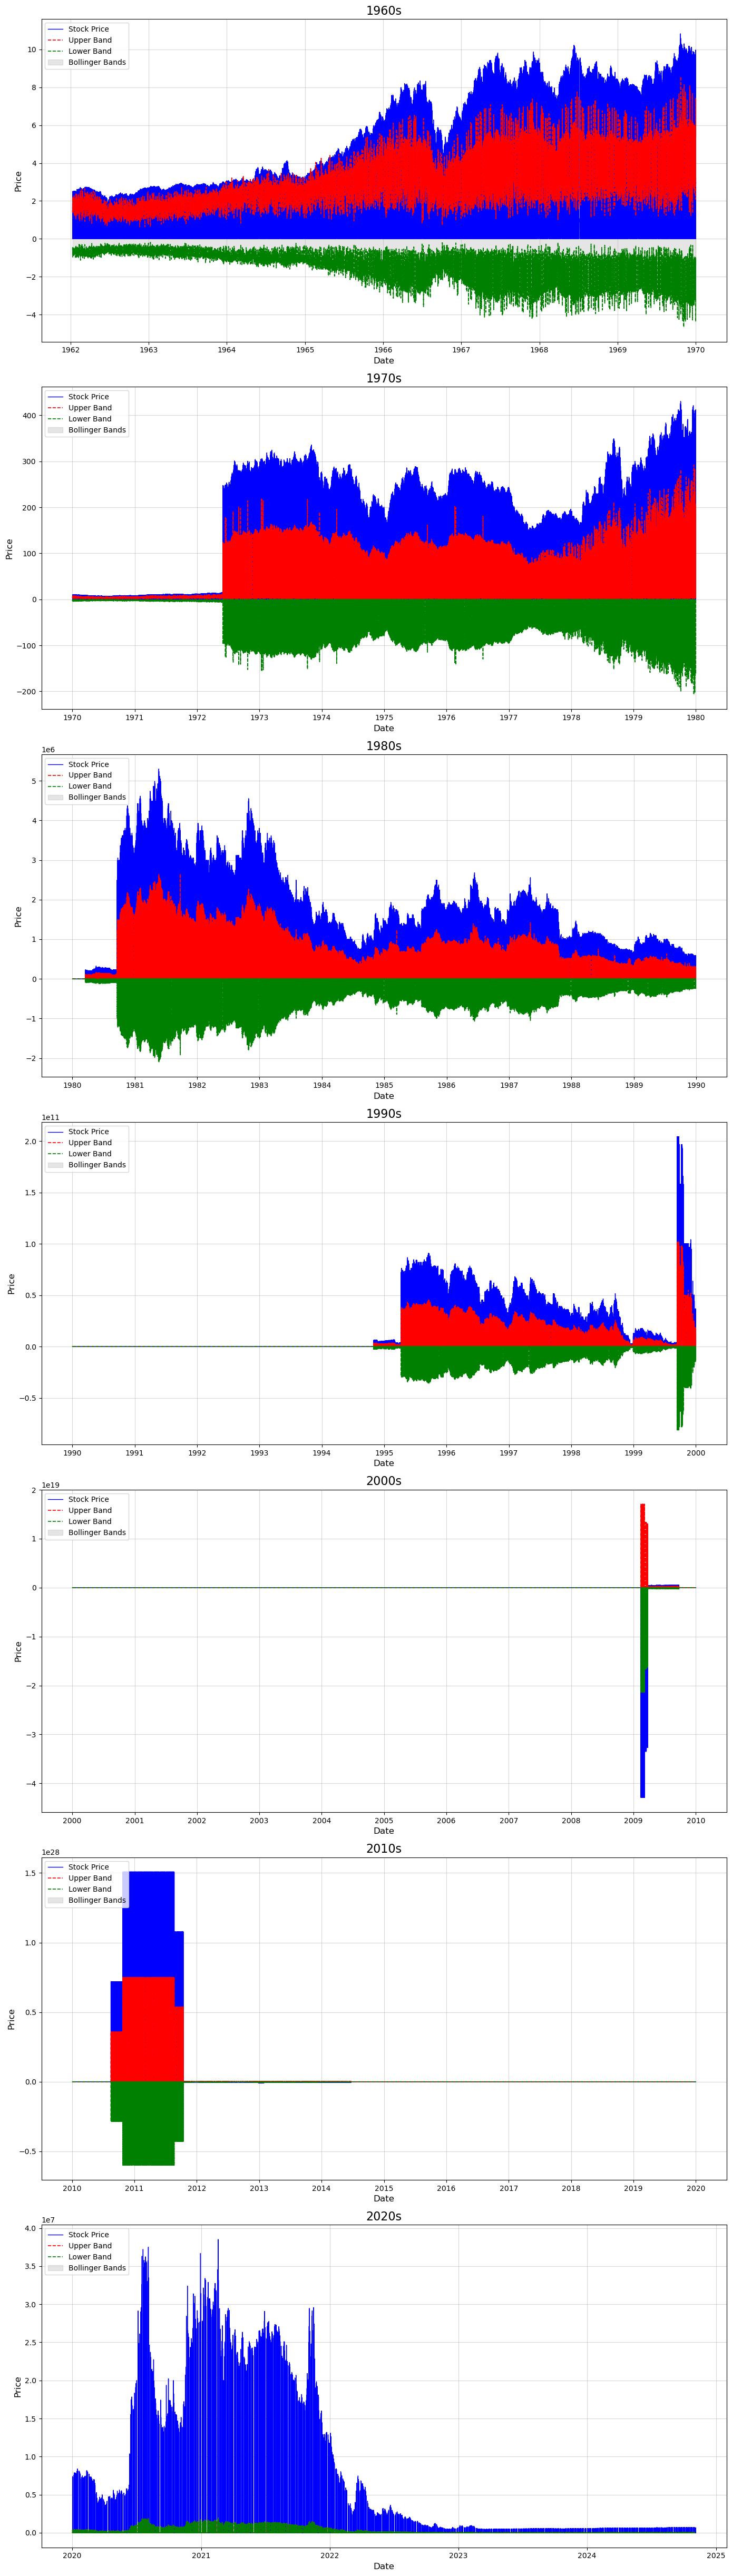

In [27]:
# Plot Bollinger Bands for each decade
n = len(dataframes)
plt.figure(figsize=(14, 7 * n))

for i, df in enumerate(dataframes):
    plt.subplot(n, 1, i + 1)
    
    # Plot stock price
    plt.plot(df['Date'], df['Close'], label='Stock Price', color='blue', linewidth=1)
    
    # Plot Bollinger Bands
    plt.plot(df['Date'], df['Upper_Band'], label='Upper Band', color='red', linestyle='--', linewidth=1.2)
    plt.plot(df['Date'], df['Lower_Band'], label='Lower Band', color='green', linestyle='--', linewidth=1.2)
    plt.fill_between(df['Date'], df['Upper_Band'], df['Lower_Band'], color='grey', alpha=0.2, label='Bollinger Bands')
    
    # Add title, labels, and legend
    plt.title(list(decade_dataframes.keys())[i], fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Insights from Bollinger Bands vs Stock Price (1960s - 2020s)**

- **1960s**
  - Stock prices mostly remain within the Bollinger Bands, indicating stable market behavior.
  - The upper and lower bands widen gradually over the decade, reflecting increased volatility.
  - Price movements closely align with the upper band during bullish trends, especially after 1965.

- **1970s**
  - Stock prices show higher volatility, with frequent touches on both upper and lower bands.
  - The widening of Bollinger Bands during mid-decade highlights periods of extreme market uncertainty.
  - Price rebounds often occur when approaching the lower band, consistent with oversold conditions.

- **1980s**
  - The Bollinger Bands display significant width, highlighting increased volatility in stock prices.
  - Price frequently oscillates between the upper and lower bands, signaling volatile market momentum.
  - The upper band serves as a resistance level during bullish trends, while the lower band signals support.

- **1990s**
  - Stock prices demonstrate consistent growth, often testing the upper Bollinger Band.
  - Narrower band width during mid-decade suggests reduced market volatility.
  - Significant widening of the bands toward the end of the decade reflects increasing price fluctuations.

- **2000s**
  - The Bollinger Bands widen dramatically during the 2008 financial crisis, indicating unprecedented market volatility.
  - Stock prices frequently breach the lower band during market downturns, signaling strong bearish momentum.
  - Recovery towards the end of the decade narrows the bands, reflecting stabilizing conditions.

- **2010s**
  - Stock prices show a sharp recovery early in the decade, testing the upper band frequently.
  - Bollinger Bands remain relatively narrow throughout the decade, indicating reduced market volatility.
  - Price movements remain largely within the bands, showing a well-regulated market behavior.

- **2020s**
  - Significant volatility in stock prices during the early years, with frequent breaches of both bands.
  - The widening of Bollinger Bands highlights extreme market reactions to events like the COVID-19 pandemic.
  - Stock prices stabilize towards the latter part of the period, narrowing the bands.

**General Observations**
- **Bollinger Bands**:
  - The bands effectively capture periods of high and low volatility across decades.
  - Widening of bands correlates with market disruptions, while narrowing indicates stabilization.
- **Stock Price Movements**:
  - Price touching or breaching the upper band often signals overbought conditions, while the lower band signals oversold conditions.
  - Consistent behavior within the bands reflects a balanced market, whereas frequent breaches suggest high uncertainty.
- Bollinger Bands remain a reliable indicator for analyzing volatility and potential reversal points in stock prices.


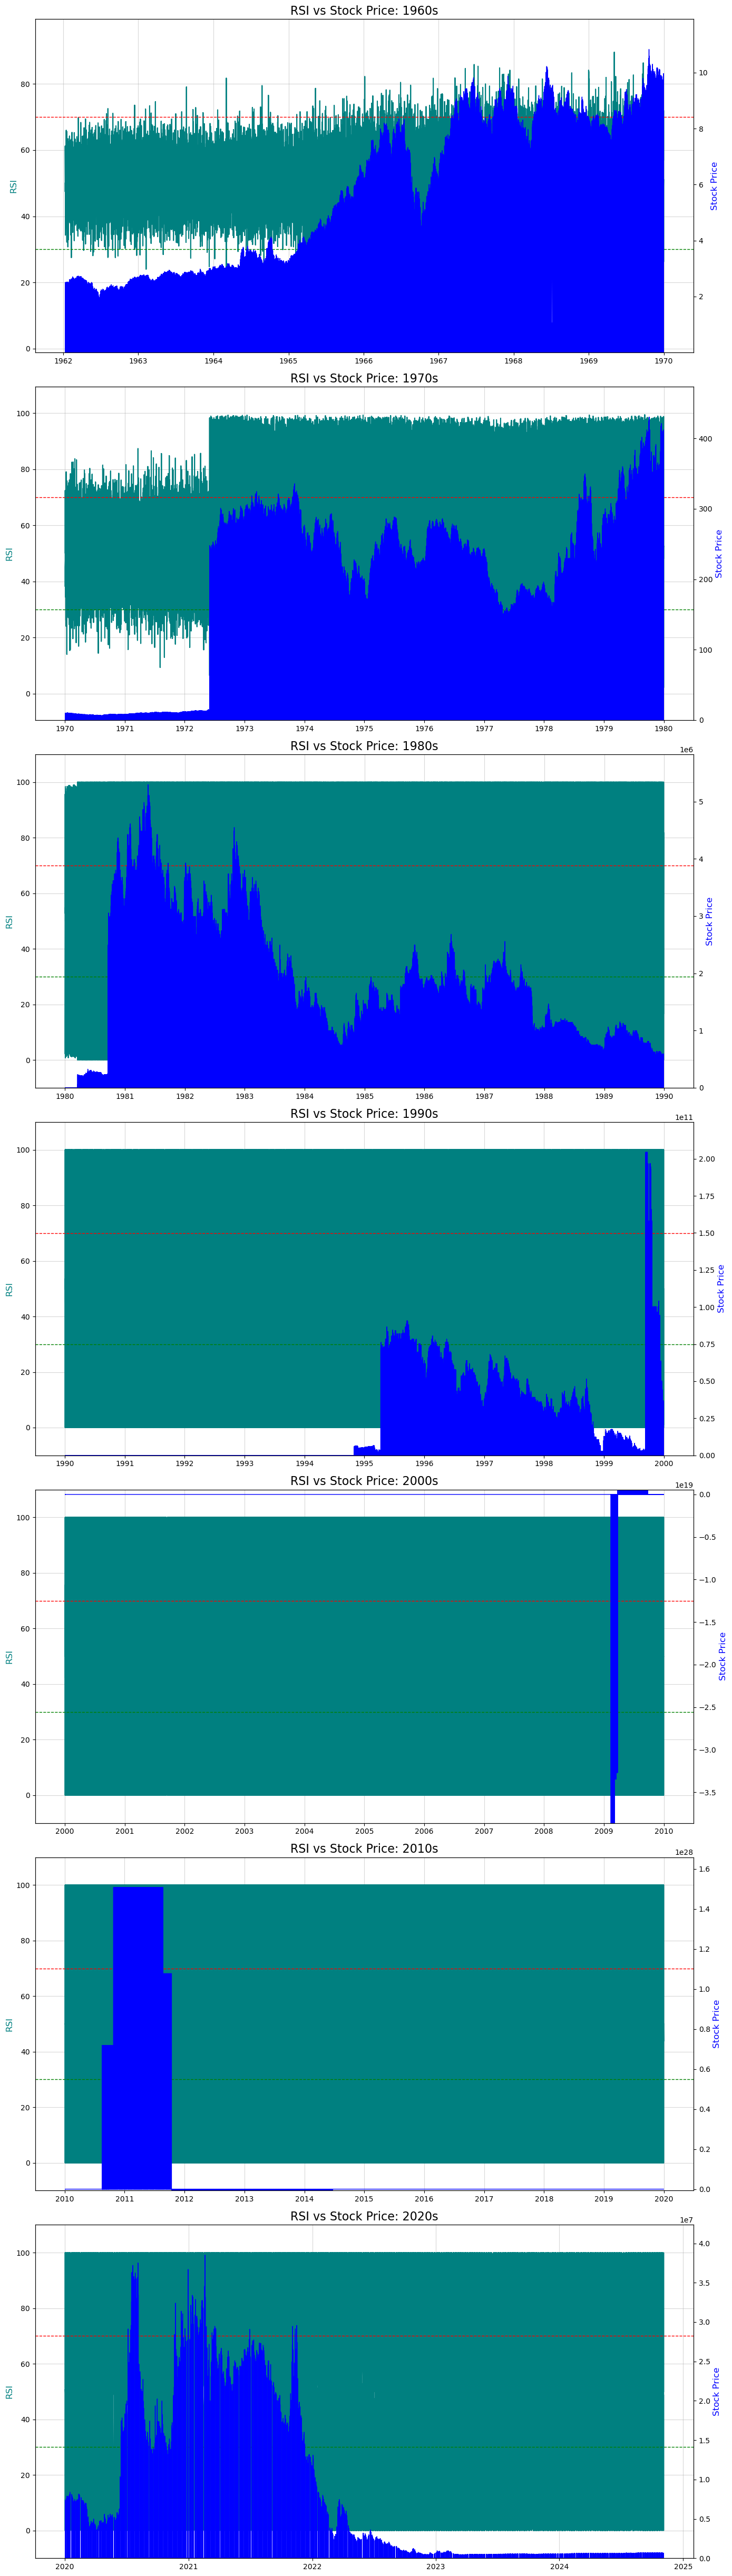

In [28]:
# Plot RSI with dynamic y-axis scaling for each decade
n = len(dataframes)
plt.figure(figsize=(14, 7 * n))

for i, df in enumerate(dataframes):
    plt.subplot(n, 1, i + 1)
    
    # Create a twin axis
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Get dynamic ranges for y-axis
    rsi_min, rsi_max = df['RSI'].min(), df['RSI'].max()
    price_min, price_max = df['Close'].min(), df['Close'].max()
    
    # Plot RSI on the left axis
    ax1.plot(df['Date'], df['RSI'], label='RSI', color='teal', linewidth=1.5)
    ax1.axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
    ax1.axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
    ax1.set_ylabel("RSI", fontsize=12, color='teal')
    ax1.set_ylim(rsi_min - 10, rsi_max + 10)  # Dynamically set RSI y-axis limits
    
    # Plot the stock price on the right axis
    ax2.plot(df['Date'], df['Close'], label='Stock Price', color='blue', linewidth=1)
    ax2.set_ylabel("Stock Price", fontsize=12, color='blue')
    ax2.set_ylim(price_min * 0.9, price_max * 1.1)  # Dynamically set stock price y-axis limits
    
    # Add title and grid
    plt.title(f"RSI vs Stock Price: {list(decade_dataframes.keys())[i]}", fontsize=16)
    ax1.grid(alpha=0.5)
    plt.xlabel("Date", fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Insights from RSI vs Stock Price (1960s - 2020s)**

- **1960s**
  - Relative Strength Index (RSI) generally stays within a moderate range, with occasional spikes.
  - Stock prices show steady growth, aligning with increases in RSI.
  - RSI values rarely exceed the overbought threshold of 70 or drop below the oversold threshold of 30.

- **1970s**
  - RSI shows increased variability compared to the 1960s, indicating more frequent shifts in momentum.
  - Stock prices experience volatility, particularly in the mid-decade, reflecting market uncertainty.
  - Significant periods where RSI exceeds 70, indicating overbought conditions, align with stock price peaks.

- **1980s**
  - RSI exhibits high volatility, with frequent overbought and oversold signals.
  - Stock prices follow sharp rises and falls, mirroring RSI movements.
  - Clear correlation between extreme RSI values and reversals in stock price trends.

- **1990s**
  - RSI shows less fluctuation compared to the 1980s, with fewer overbought and oversold instances.
  - Stock prices demonstrate consistent growth, aligning with a steady RSI range.
  - Stabilization in RSI and price trends may indicate a more mature market phase.

- **2000s**
  - RSI signals are highly irregular, particularly during the 2008 financial crisis.
  - Stock prices plummet sharply, correlating with extreme RSI volatility.
  - RSI highlights prolonged oversold conditions during market downturns, with limited recovery by decade’s end.

- **2010s**
  - RSI shows a strong rebound early in the decade, with consistent signals around the neutral zone (50).
  - Stock prices grow significantly in the early years, stabilizing later in the decade.
  - Fewer instances of RSI hitting extreme thresholds reflect reduced volatility in the market.

- **2020s**
  - RSI fluctuates sharply during the early years, influenced by events like the COVID-19 pandemic.
  - Stock prices show dramatic peaks and troughs, aligning with RSI extremes.
  - Volatility decreases in later years, with RSI and stock prices stabilizing towards the end of the observed period.

**General Observations**
- **RSI Trends**:
  - RSI effectively signals overbought (RSI > 70) and oversold (RSI < 30) conditions across decades.
  - High RSI volatility often precedes or coincides with market disruptions.
- **Stock Price Movements**:
  - Strong alignment between RSI trends and stock price movements, especially during major market events.
  - Stabilization of RSI in later decades corresponds to reduced market volatility.
- RSI serves as a valuable tool for identifying momentum shifts and potential price reversals.


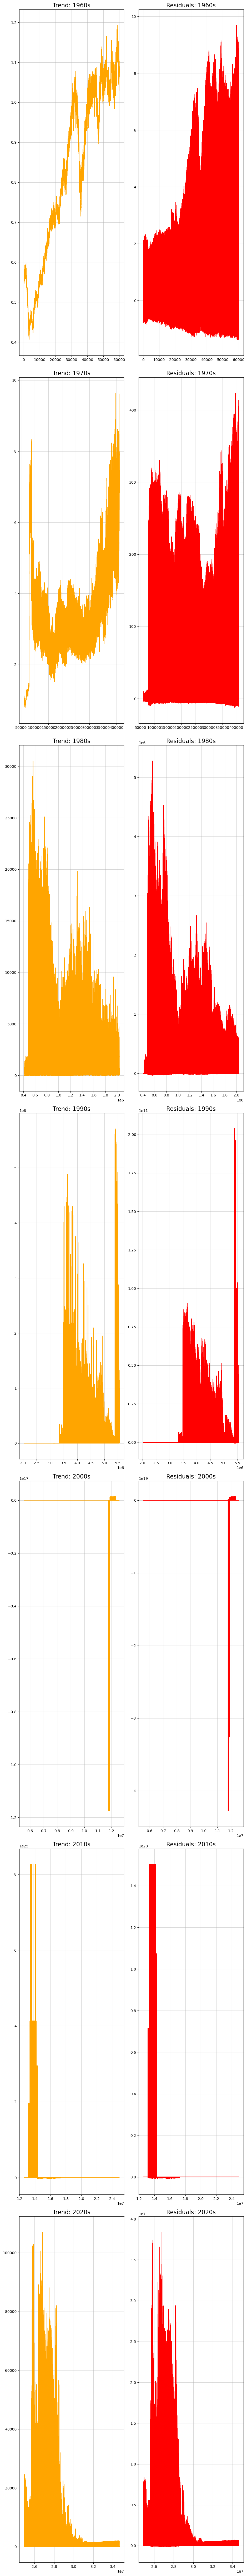

In [ ]:
# Apply seasonal decomposition to each dataframe
n = len(dataframes)
plt.figure(figsize=(14, 7 * n * 2))  # Multiply height for 3 subplots per dataframe

for i, df in enumerate(dataframes):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(df['Close'], model='additive', period=365)  # Assuming daily data

    # Plot decomposition
    plt.subplot(n, 3, i * 3 + 1)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.title(f"Trend: {list(decade_dataframes.keys())[i]}", fontsize=16)
    plt.grid(alpha=0.5)

    plt.subplot(n, 3, i * 3 + 2)
    plt.plot(decomposition.resid, label='Residuals', color='red')
    plt.title(f"Residuals: {list(decade_dataframes.keys())[i]}", fontsize=16)
    plt.grid(alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Insights from Seasonal Decomposition**

- **Purpose of Analysis**
  - The seasonal decomposition process is applied to analyze time series data for different decades.
  - The goal is to break down the data into three components: **trend**, **seasonality**, and **residuals**, which help identify:
    - **Trend**: Long-term patterns in the data.
    - **Seasonality**: Repetitive patterns at regular intervals.
    - **Residuals**: Noise or unexplained variations in the data.

**Trend Analysis**

- **Trend Component**:
  - The trend represents the overall direction of the data over time.
  - **Key Observations**:
    - In earlier decades, the trend may show a consistent upward or downward movement, reflecting growth or decline.
    - Sudden changes in the trend might indicate major events or disruptions.
    - In later decades, smoother trends could suggest reduced volatility or market stabilization.

**Residuals Analysis**

- **Residual Component**:
  - Residuals indicate the noise or randomness in the data after removing the trend and seasonality.
  - **Key Observations**:
    - Larger residuals in earlier decades may suggest higher unpredictability or external shocks.
    - Consistent clustering of residuals in specific time periods could point to anomalies or irregular patterns.
    - Smaller residuals in recent decades may indicate a better fit of the model or reduced noise.

**General Observations**

- **Trend Plots**:
  - The orange lines represent the overall movement in the data, highlighting growth, decline, or stagnation.
- **Residual Plots**:
  - The red lines show unexplained variations, which can be analyzed further to identify anomalies or errors.
- Seasonal decomposition is a valuable tool for understanding time series data and can improve forecasting accuracy.


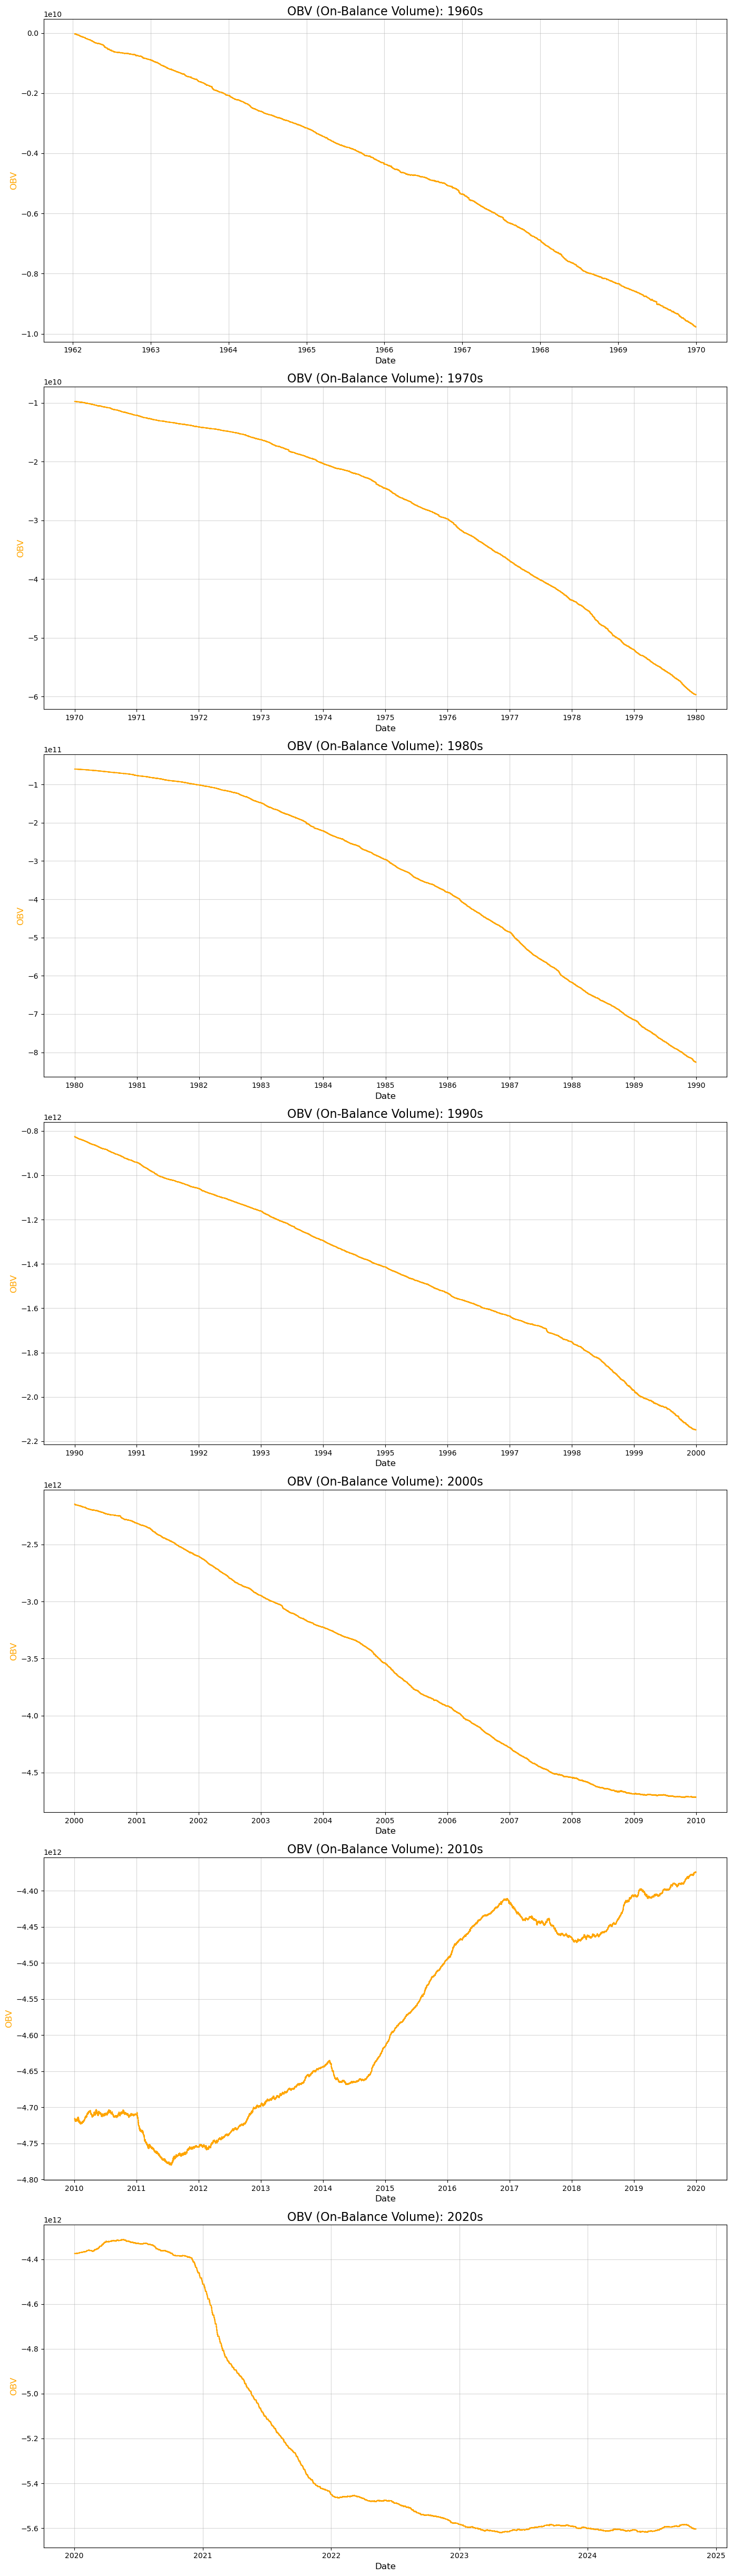

In [30]:
# Plot OBV for each decade
n = len(dataframes)  # Number of dataframes
plt.figure(figsize=(14, 7 * n))  # Adjust height to accommodate all plots

for i, df in enumerate(dataframes):
    plt.subplot(n, 1, i + 1)
    
    # Plot OBV
    plt.plot(df['Date'], df['OBV'], label='OBV (On-Balance Volume)', color='orange', linewidth=1.5)
    
    # Add title, labels, and grid
    plt.title(f"OBV (On-Balance Volume): {list(decade_dataframes.keys())[i]}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("OBV", fontsize=12, color='orange')
    plt.grid(alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Insights from On-Balance Volume (OBV) Analysis (1960s - 2020s)**

- **1960s**
  - OBV shows a steady downward trend throughout the decade.
  - Indicates consistent selling pressure or a lack of strong accumulation.
  - Minimal fluctuations suggest a relatively stable trading volume environment.

- **1970s**
  - OBV continues the downward trend observed in the 1960s.
  - The slope becomes steeper in certain periods, reflecting increased selling activity or declining market confidence.
  - The trend suggests that selling pressure dominated the market during this decade.

- **1980s**
  - OBV shows a persistent decline, with a steeper slope compared to earlier decades.
  - Reflects intensified selling pressure or distribution of shares over time.
  - Consistent downward movement aligns with volatile market conditions in this period.

- **1990s**
  - OBV initially continues its decline but shows a sudden drop mid-decade, likely reflecting a significant market event.
  - After the drop, the trend stabilizes but remains in a declining trajectory.
  - Suggests a period of market correction or redistribution of shares.

- **2000s**
  - OBV maintains a consistent downward trend throughout the decade.
  - The sharp decline during the 2008 financial crisis highlights significant selling pressure.
  - Recovery is limited by the end of the decade, indicating weak accumulation.

- **2010s**
  - OBV shows an initial stabilization, followed by a strong upward movement starting in the mid-decade.
  - Reflects a shift from selling pressure to accumulation as market confidence improves.
  - The upward trend indicates a bullish market sentiment during the latter half of the decade.

- **2020s**
  - OBV experiences sharp volatility during the early years, influenced by events like the COVID-19 pandemic.
  - After a significant decline in 2021, OBV stabilizes towards the end of the period.
  - Suggests a transition from panic-driven selling to more balanced trading volume activity.

**General Observations**
- **Trends Over Decades**:
  - Consistent downward trends in OBV during earlier decades (1960s-2000s) suggest prolonged selling pressure and weak accumulation.
  - The upward shift in OBV during the mid-2010s indicates growing market confidence and accumulation by investors.
- **Market Events**:
  - Sharp drops in OBV align with major market downturns, such as the 2008 financial crisis and COVID-19 pandemic.
  - Recovery phases are characterized by a flattening or upward movement in OBV.
- **Interpretation**:
  - OBV is a useful indicator of trading volume trends, helping to identify periods of accumulation (upward OBV) and distribution (downward OBV).


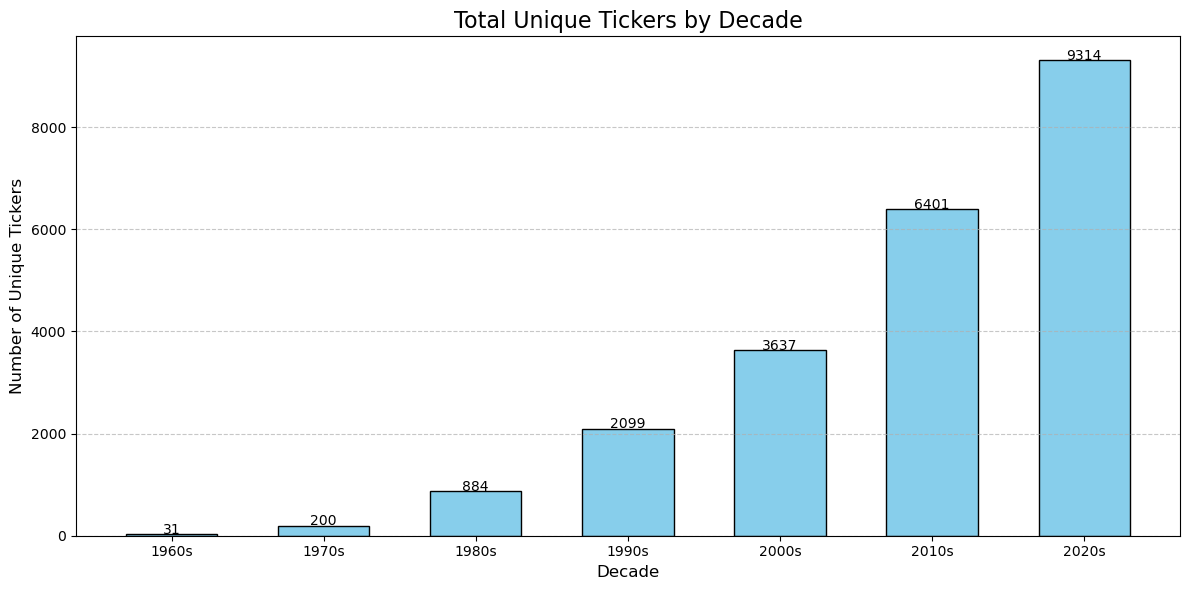

In [31]:
# Calculate the total unique tickers for each decade
unique_tickers_by_decade = {decade: df['Ticker'].nunique() for decade, df in decade_dataframes.items()}

# Convert to a sorted list for consistent ordering
decades = list(unique_tickers_by_decade.keys())
unique_tickers = list(unique_tickers_by_decade.values())

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(decades, unique_tickers, color='skyblue', edgecolor='black', width=0.6)

# Add title, labels, and grid
plt.title("Total Unique Tickers by Decade", fontsize=16)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Number of Unique Tickers", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations on top of bars
for i, value in enumerate(unique_tickers):
    plt.text(decades[i], value + 1, str(value), ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


**Insights from Total Unique Tickers by Decade**

- **1960s**
  - Only 31 unique tickers were observed during this decade.
  - Represents the early stage of the market with limited companies trading.

- **1970s**
  - A significant increase to 200 unique tickers.
  - Indicates growth in the market and participation by more companies.

- **1980s**
  - The number of unique tickers grows to 884.
  - Reflects increased investor participation and company listings during this period.

- **1990s**
  - A further rise to 2,099 unique tickers.
  - Highlights the expansion of the market, possibly driven by globalization and technological advancements.

- **2000s**
  - Unique tickers reach 3,637, showing steady growth.
  - Likely influenced by the dot-com boom and increased awareness of stock markets.

- **2010s**
  - A dramatic increase to 6,401 unique tickers.
  - Represents a more mature and diversified market with a large number of active companies.

- **2020s**
  - Unique tickers surge to 9,314, the highest among all decades.
  - Reflects the modern market era with increased accessibility, globalization, and participation by newer industries.

**General Observations**
- The number of unique tickers has grown exponentially over the decades, indicating a consistent expansion of market participation and company listings.
- The largest growth occurred in the last two decades (2010s and 2020s), suggesting the impact of technological advancements and easier access to financial markets.
- The upward trend highlights the market's evolution and the increasing importance of equities as an investment tool globally.


In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

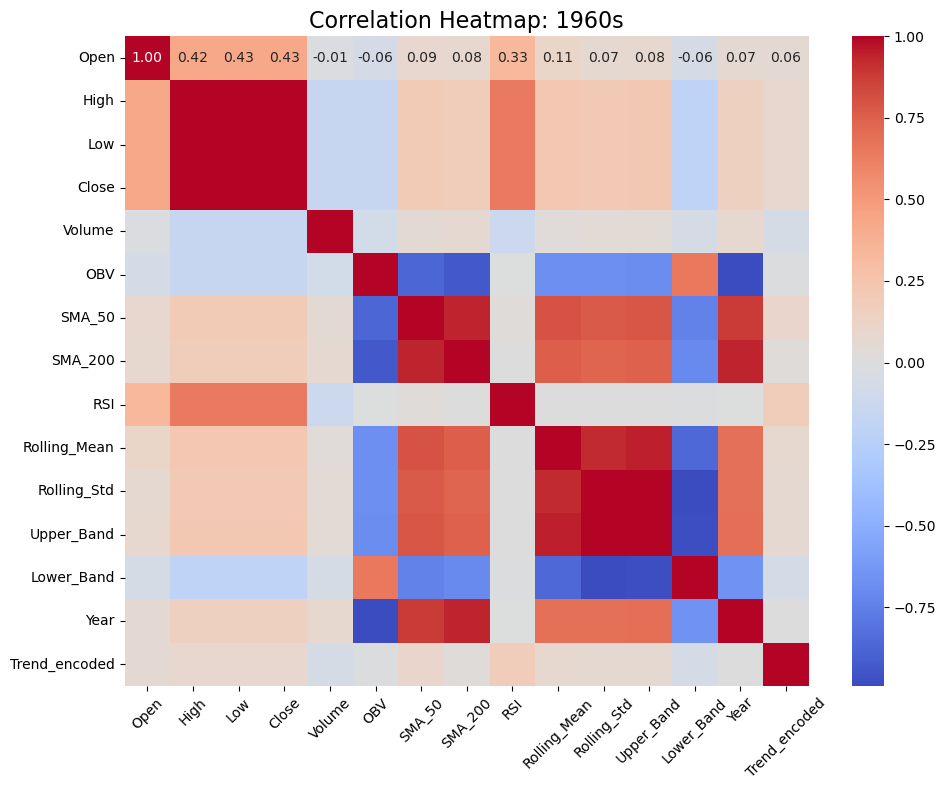

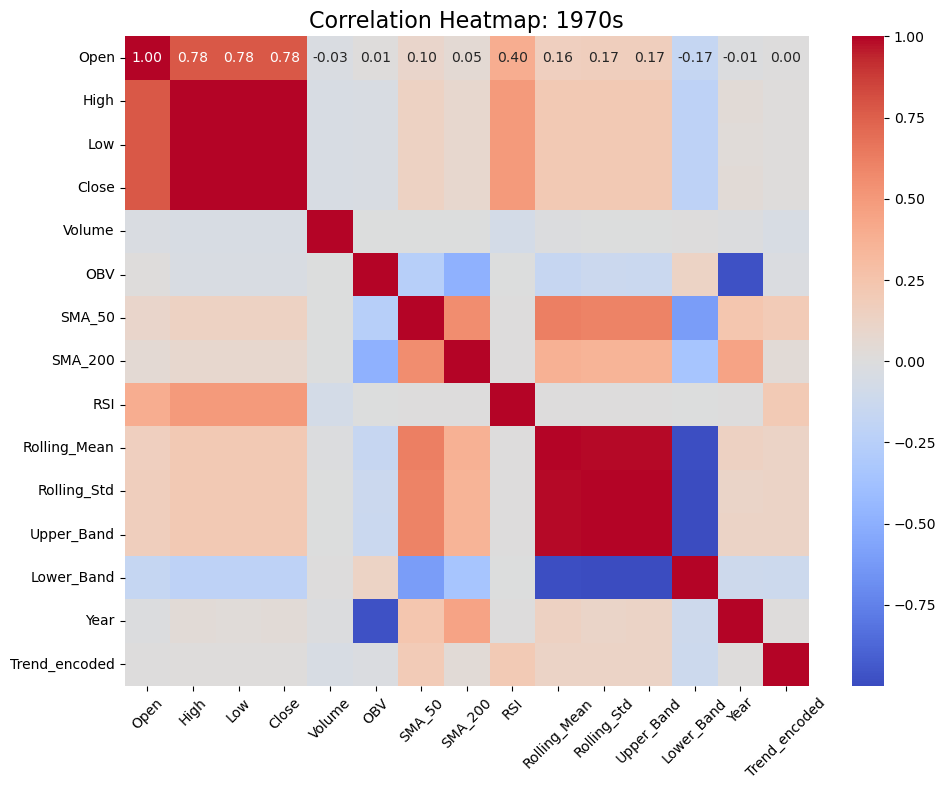

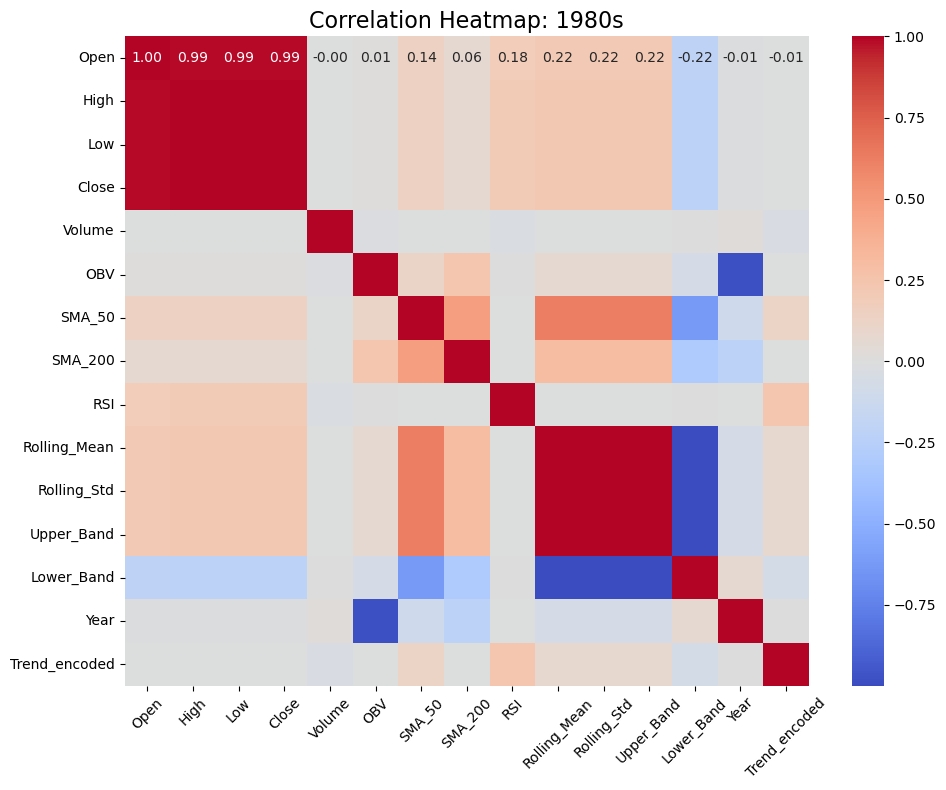

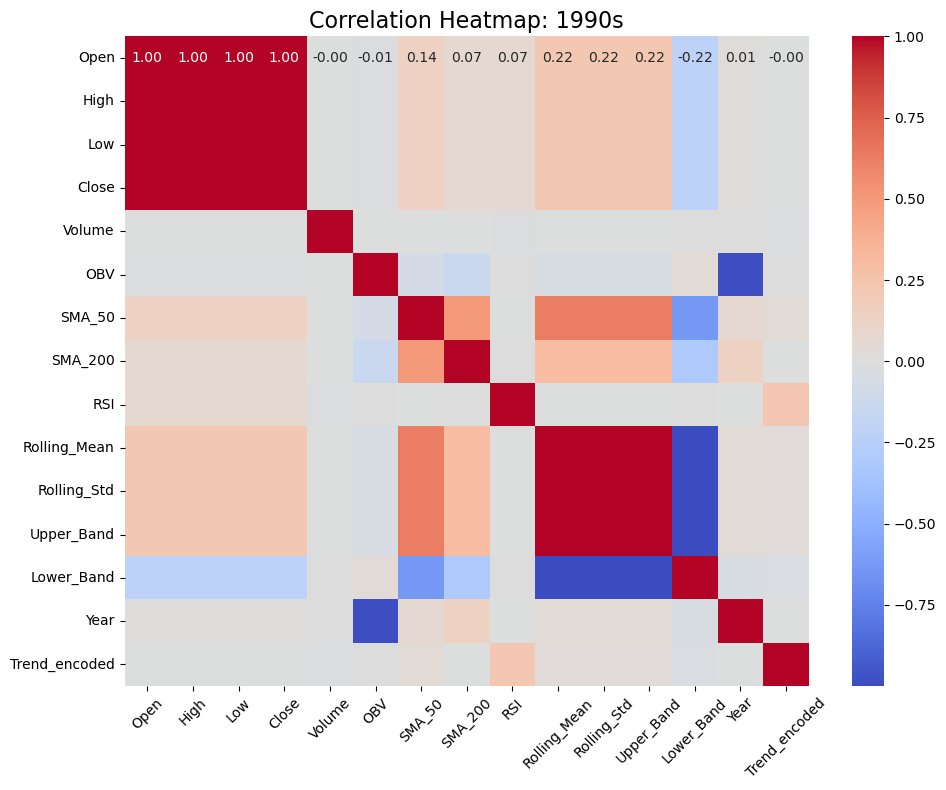

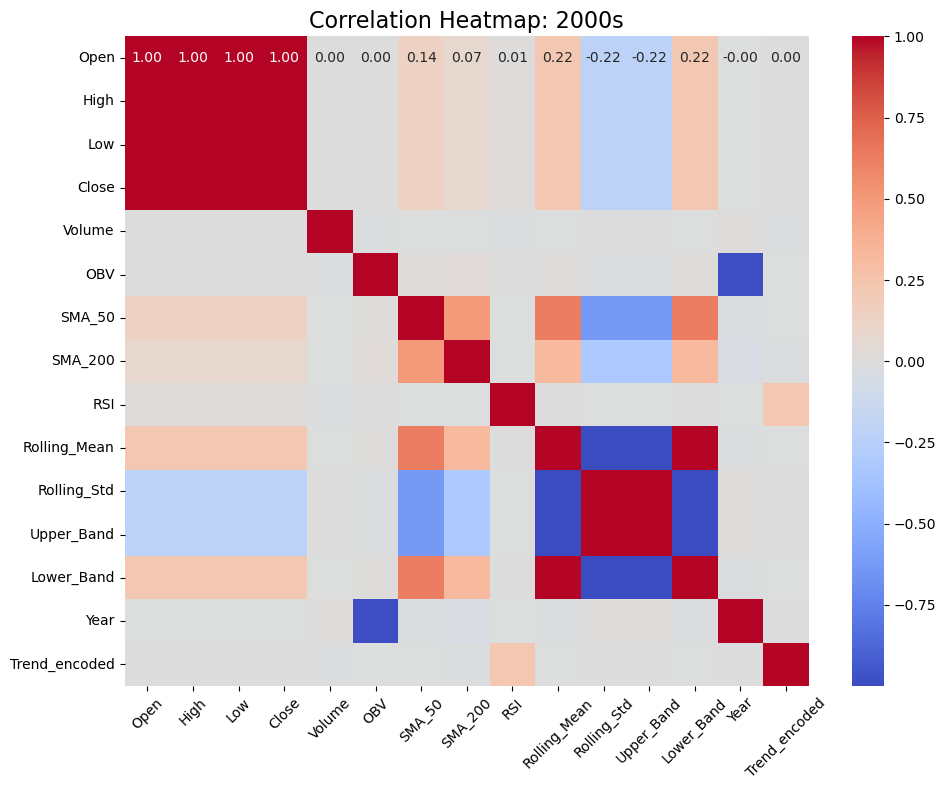

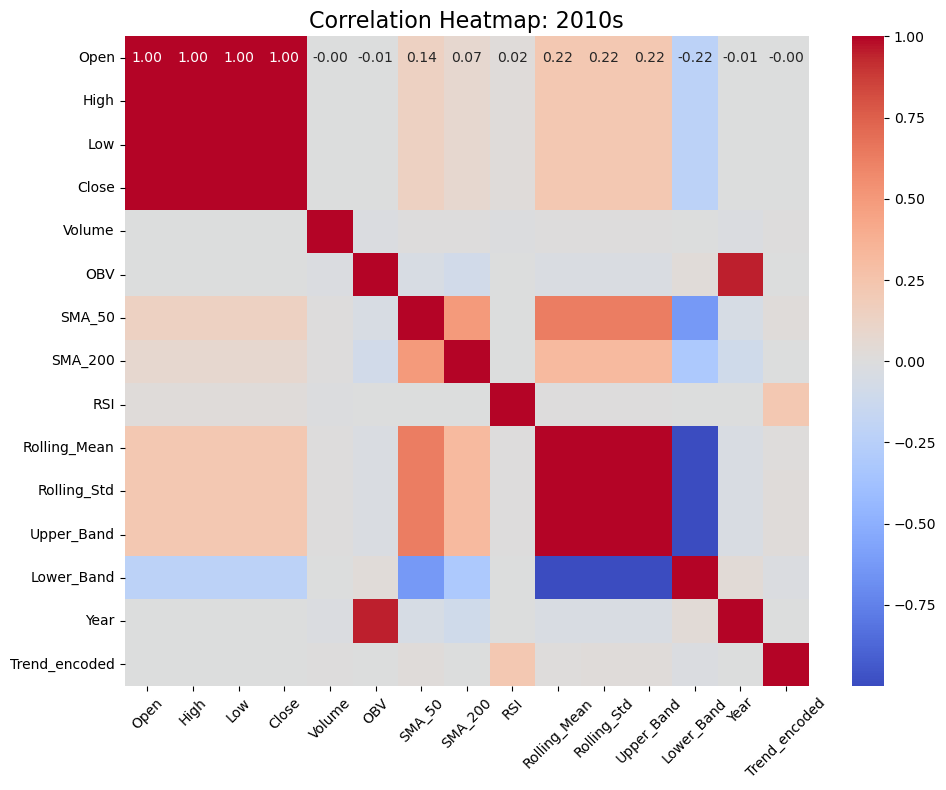

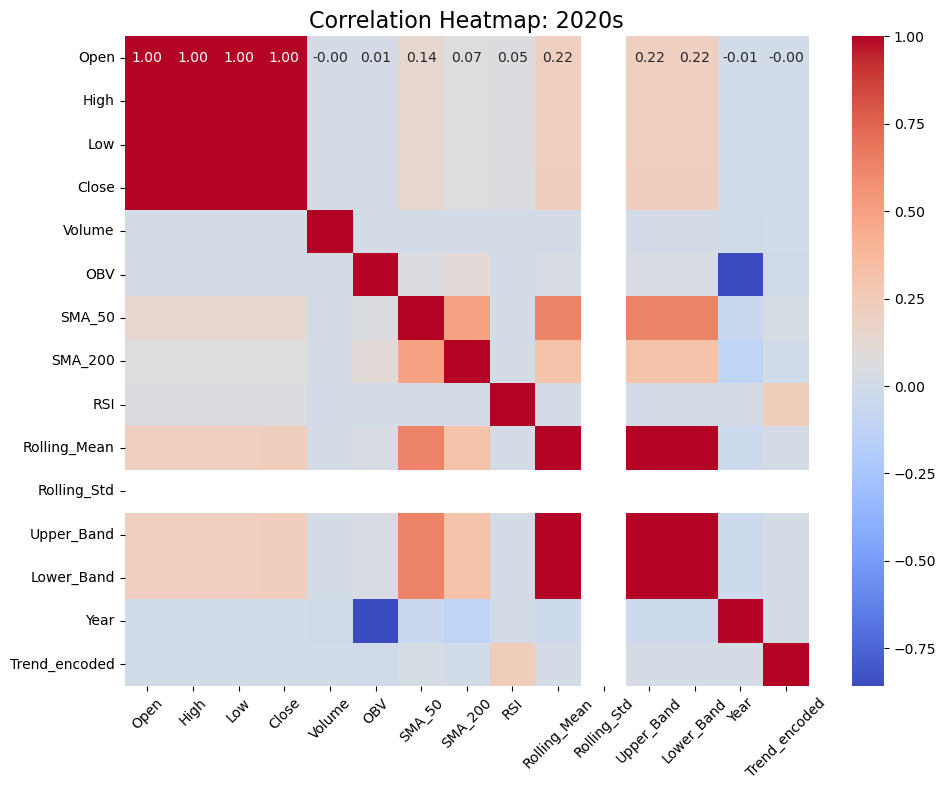

In [33]:
for i, (key, df) in enumerate(decade_dataframes.items()):  # Assuming you are iterating over a dictionary

    df['Trend_encoded'] = label_encoder.fit_transform(df['Trend'])
    
    # Select relevant columns for correlation (ensure columns exist in each dataframe)
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns 

    # Compute correlation matrix
    correlation_data = df[numeric_columns].corr()

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title(f"Correlation Heatmap: {key}", fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

### Association Rule

In [34]:
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,OBV,SMA_50,SMA_200,RSI,Rolling_Mean,Rolling_Std,Upper_Band,Lower_Band,Trend,Year,Trend_encoded
24919131,2020-01-02,HOFV,232.320007,232.539993,231.660004,231.660004,11459.0,-4.374475e+12,579.947402,25577.861173,50.684098,374.971425,0.0,374.971425,374.971425,Sideways,2020,2
24919132,2020-01-02,CTSH,61.055629,61.222259,60.457717,60.692959,2234500.0,-4.374477e+12,580.473261,25577.898838,50.208087,376.817714,0.0,376.817714,376.817714,Sideways,2020,2
24919133,2020-01-02,AZUL,43.610001,44.080002,43.150002,43.590000,532300.0,-4.374478e+12,581.205061,25577.989246,50.101562,378.092500,0.0,378.092500,378.092500,Sideways,2020,2
24919134,2020-01-02,FNCTF,12.707134,12.707134,12.707134,12.707134,100.0,-4.374478e+12,581.323204,25577.970432,6.046410,377.850856,0.0,377.850856,377.850856,Bearish,2020,0
24919135,2020-01-02,BLE,13.720488,13.720488,13.621064,13.657218,54700.0,-4.374477e+12,581.566349,25577.315568,50.576852,375.097717,0.0,375.097717,375.097717,Sideways,2020,2


In [35]:
df['Close_Category'] = pd.qcut(df['Close'], q=3, labels=['Low', 'Medium', 'High'])
df['Volume_Category'] = pd.qcut(df['Volume'], q=3, labels=['Low', 'Medium', 'High'])
df['RSI_Category'] = pd.cut(df['RSI'], bins=[-1, 30, 70, 100], labels=['Oversold', 'Neutral', 'Overbought'])

In [36]:
# Create a list of transactions 
transactions = df[['Close_Category', 'Volume_Category', 'RSI_Category', 'Trend']].apply(lambda x: list(x), axis=1).tolist()

In [ ]:
# Encode transactions into a one-hot matrix
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric='lift', min_threshold=1.0)

# Display rules
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Bearish),(Low),0.312454,0.531139,0.218320,0.698728,1.315528,1.0,0.052364,1.556272,0.348848,0.349160,0.357439,0.554885
1,(Low),(Bearish),0.531139,0.312454,0.218320,0.411042,1.315528,1.0,0.052364,1.167394,0.511556,0.349160,0.143391,0.554885
2,(Medium),(Bearish),0.542860,0.312454,0.173412,0.319441,1.022363,1.0,0.003793,1.010267,0.047850,0.254306,0.010163,0.437221
3,(Bearish),(Medium),0.312454,0.542860,0.173412,0.555001,1.022363,1.0,0.003793,1.027281,0.031815,0.254306,0.026557,0.437221
4,(Bearish),(Neutral),0.312454,0.953974,0.300488,0.961703,1.008102,1.0,0.002415,1.201811,0.011689,0.311083,0.167922,0.638344
5,(Neutral),(Bearish),0.953974,0.312454,0.300488,0.314985,1.008102,1.0,0.002415,1.003695,0.174609,0.311083,0.003682,0.638344
6,(High),(Bullish),0.509101,0.187459,0.128798,0.252992,1.349585,1.0,0.033363,1.087727,0.527668,0.226853,0.080652,0.470033
7,(Bullish),(High),0.187459,0.509101,0.128798,0.687075,1.349585,1.0,0.033363,1.568744,0.318792,0.226853,0.362547,0.470033
8,(High),(Sideways),0.509101,0.500087,0.273788,0.537786,1.075385,1.0,0.019193,1.081562,0.142800,0.372297,0.075411,0.542633
9,(Sideways),(High),0.500087,0.509101,0.273788,0.547480,1.075385,1.0,0.019193,1.084811,0.140225,0.372297,0.078180,0.542633


**Insights from Association Rule Mining**

- **Key Relationships**:
  - **Low → Bearish**: Stocks categorized as "Low" are strongly associated with "Bearish" market trends, with a confidence of 41.1% and a lift of 1.31, indicating a meaningful relationship.
  - **Bearish → Low**: "Bearish" trends are also strongly linked to "Low" stocks, with a confidence of 69.8% and the same lift (1.31), reinforcing the bidirectional relationship.

- **Medium and Neutral States**:
  - **Medium → Bearish**: Stocks labeled "Medium" have a moderate association with "Bearish" trends (confidence: 31.9%, lift: 1.02), suggesting a weaker but notable link.
  - **Neutral → Bearish**: Stocks labeled "Neutral" exhibit a weaker association with "Bearish" trends (confidence: 31.5%, lift: 1.01), implying neutrality often aligns with bearish movements but lacks strong predictiveness.

- **High and Bullish Trends**:
  - **Bullish → High**: "Bullish" trends are strongly tied to "High" stocks, with a confidence of 68.7% and a lift of 1.34, showcasing a significant relationship.
  - **High → Bullish**: Similarly, "High" stocks are often associated with "Bullish" trends, though the confidence is lower at 25.3%, suggesting this relationship is less consistent.

- **Sideways Market**:
  - **High → Sideways**: Stocks categorized as "High" are moderately associated with "Sideways" trends (confidence: 53.8%, lift: 1.07), indicating occasional market stagnation at high levels.
  - **Sideways → High**: Sideways trends often align with "High" stocks (confidence: 54.7%), showing a similar pattern with marginally higher consistency.

- **Complex Relationships**:
  - **Low, Neutral → Bearish**: The combination of "Low" and "Neutral" stock states strongly predicts a "Bearish" trend (confidence: 41.6%, lift: 1.33), suggesting that mixed states are significant bearish indicators.
  - **Medium, Neutral → Sideways**: Stocks that are "Medium" and "Neutral" are weakly associated with "Sideways" trends (confidence: 50.2%, lift: 1.00), showing minimal predictive value.

- **General Observations**:
  - Confidence values above 50% often indicate stronger predictive power, particularly for trends like **Bearish → Low** and **Bullish → High**.
  - Lift values above 1 demonstrate meaningful associations. Notably, relationships like **Low → Bearish** and **Bullish → High** stand out as significant.
  - Metrics like leverage and Zhang’s metric highlight the practical significance of the rules, with values such as 0.052 for **Low → Bearish** confirming its impact.

- **Neutral and Transitionary Patterns**:
  - "Neutral" states frequently co-occur with various trends (e.g., **Neutral → Low, Bearish**), but the associations are often weak, highlighting its role as a transitional or ambiguous state.
  - **Medium, Sideways, Low → Neutral**: A unique combination of "Medium," "Sideways," and "Low" stocks strongly predicts a "Neutral" state with confidence close to 97.4% and lift of 1.02.

- **Practical Implications**:
  - These insights can guide stock traders to predict market trends based on combinations of stock states and indicators.
  - The strong associations between "Low" or "High" stock levels and their respective market trends (Bearish/Bullish) provide actionable signals for trading strategies.


### Model Training

In [41]:
# 1. Data Preprocessing
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Prepare the data
def prepare_data(df, batch_size=32):
    # Remove Date and Ticker columns
    X = df.drop(['Date', 'Ticker', 'Trend'], axis=1).values
    y = df['Trend'].values
    
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create datasets
    train_dataset = StockDataset(X_train_scaled, y_train)
    test_dataset = StockDataset(X_test_scaled, y_test)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader, label_encoder

# 2. Model Definitions

# ResNet-like Model
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.fc2 = nn.Linear(out_channels, out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Linear(in_channels, out_channels) if in_channels != out_channels else nn.Identity()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        return out

class ResNetModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ResNetModel, self).__init__()
        self.layer1 = ResNetBlock(input_size, 64)
        self.layer2 = ResNetBlock(64, 128)
        self.layer3 = ResNetBlock(128, 64)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc(x)
        return x

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Reshape input for LSTM (batch_size, sequence_length, input_size)
        x = x.unsqueeze(1)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, nhead=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_size, 128)
        encoder_layer = TransformerEncoderLayer(d_model=128, nhead=nhead, dim_feedforward=256, dropout=0.3)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

# 3. Training Function
def train_model(model, train_loader, test_loader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    best_test_acc = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_accuracy = 100. * correct / total
        train_loss = train_loss / len(train_loader)
        
        # Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)  # Fixed this line
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100. * correct / total
        test_loss = test_loss / len(test_loader)
        
        # Save metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Update learning rate
        scheduler.step(test_loss)
        
        # Save best model
        if test_accuracy > best_test_acc:
            best_test_acc = test_accuracy
            best_model_state = model.state_dict()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
            print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
            print('--------------------')
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model, (train_losses, test_losses, train_accuracies, test_accuracies)

# 4. Plotting Function
def plot_training_results(metrics, model_name):
    train_losses, test_losses, train_accuracies, test_accuracies = metrics
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{model_name} - Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title(f'{model_name} - Accuracy over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 5. Main execution
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, label_encoder = prepare_data(model_df)
    input_size = next(iter(train_loader))[0].shape[1]
    num_classes = 3
    
    # Initialize models
    resnet_model = ResNetModel(input_size, num_classes).to(device)
    lstm_model = LSTMModel(input_size, hidden_size=128, num_layers=2, num_classes=num_classes).to(device)
    transformer_model = TransformerModel(input_size, num_classes).to(device)
    
    # Train and evaluate ResNet model
    print("\nTraining ResNet Model...")
    resnet_model, resnet_metrics = train_model(resnet_model, train_loader, test_loader, device)
    plot_training_results(resnet_metrics, "ResNet")
    
    # Train and evaluate LSTM model
    print("\nTraining LSTM Model...")
    lstm_model, lstm_metrics = train_model(lstm_model, train_loader, test_loader, device)
    plot_training_results(lstm_metrics, "LSTM")
    
    # Train and evaluate Transformer model
    print("\nTraining Transformer Model...")
    transformer_model, transformer_metrics = train_model(transformer_model, train_loader, test_loader, device)
    plot_training_results(transformer_metrics, "Transformer")
    
    # Model Evaluation and Prediction Functions
    def evaluate_model(model, test_loader, device):
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        return np.array(all_preds), np.array(all_labels)
    
    # Evaluate all models
    models = {
        "ResNet": resnet_model,
        "LSTM": lstm_model,
        "Transformer": transformer_model
    }
    
    for name, model in models.items():
        predictions, true_labels = evaluate_model(model, test_loader, device)
        accuracy = (predictions == true_labels).mean() * 100
        
        # Convert numerical predictions back to labels
        pred_labels = label_encoder.inverse_transform(predictions)
        true_labels = label_encoder.inverse_transform(true_labels)
        
        print(f"\n{name} Model Final Evaluation:")
        print(f"Accuracy: {accuracy:.2f}%")
        
        # Calculate predictions per class
        for label in np.unique(true_labels):
            mask = true_labels == label
            class_acc = (pred_labels[mask] == true_labels[mask]).mean() * 100
            print(f"Accuracy for {label}: {class_acc:.2f}%")

# 6. For predictions with trained models
def make_predictions(model, data, device, label_encoder):
    model.eval()
    with torch.no_grad():
        inputs = torch.FloatTensor(data).to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predicted_labels = label_encoder.inverse_transform(predicted.cpu().numpy())
    return predicted_labels

def predict_new_data(new_data, models, device, label_encoder):
    predictions = {}
    for name, model in models.items():
        pred = make_predictions(model, new_data, device, label_encoder)
        predictions[name] = pred
    return predictions

Using device: cpu

Training ResNet Model...
Epoch [10/10]
Train Loss: 0.2148, Train Acc: 90.50%
Test Loss: 0.1626, Test Acc: 93.25%
--------------------


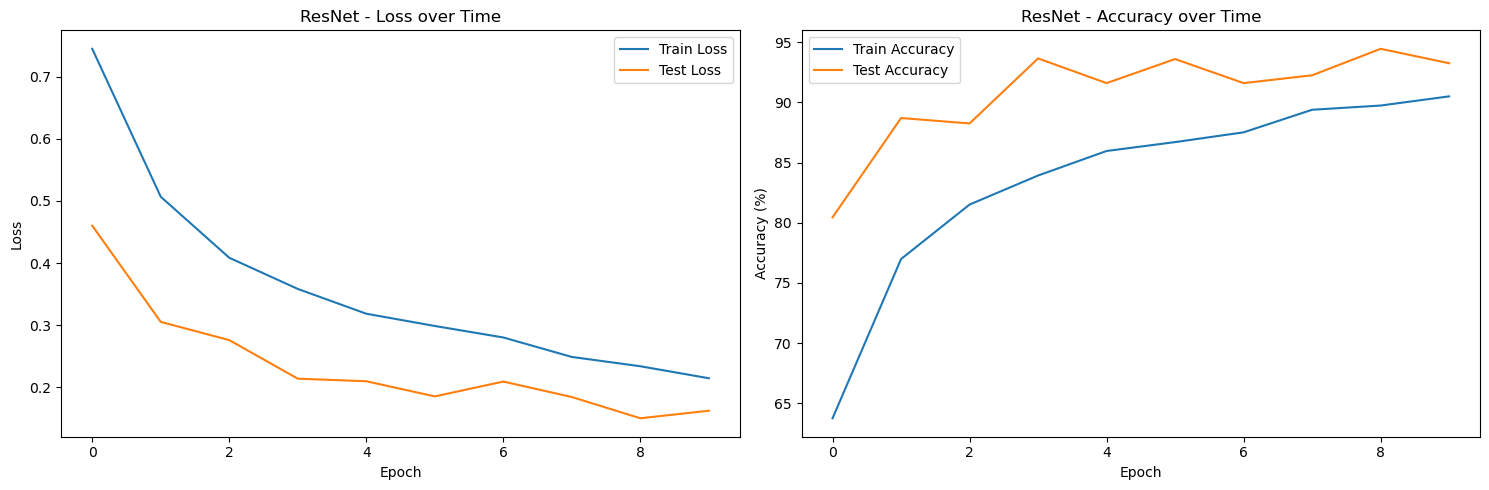


Training LSTM Model...
Epoch [10/10]
Train Loss: 0.0878, Train Acc: 96.20%
Test Loss: 0.0726, Test Acc: 97.00%
--------------------


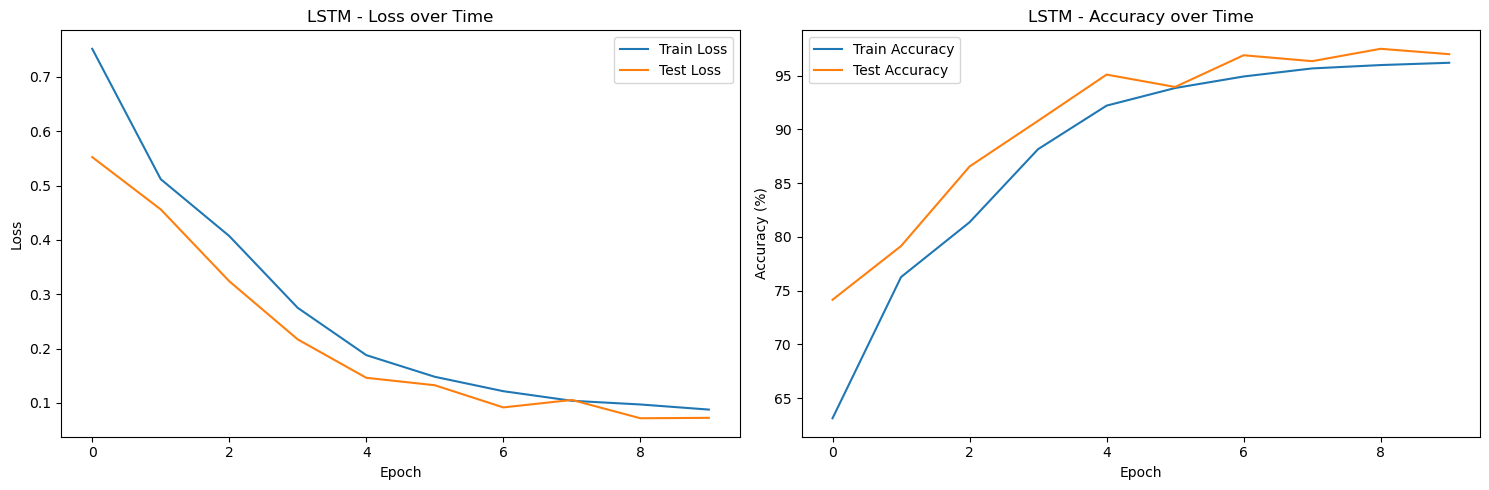


Training Transformer Model...
Epoch [10/10]
Train Loss: 0.1709, Train Acc: 93.34%
Test Loss: 0.1389, Test Acc: 93.80%
--------------------


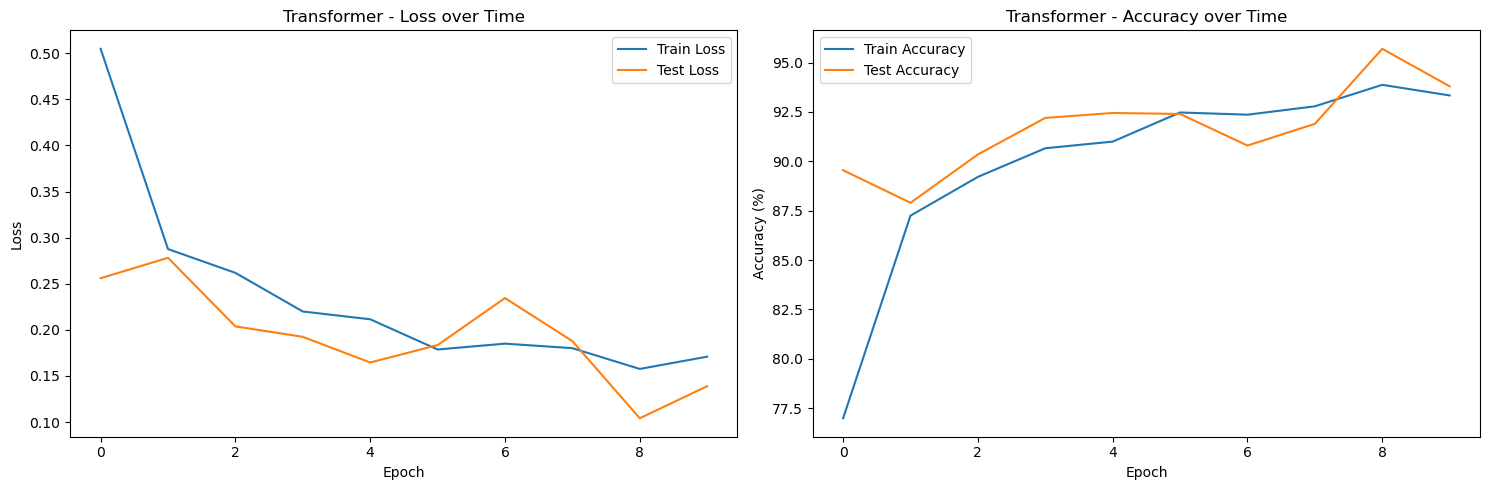


ResNet Model Final Evaluation:
Accuracy: 93.25%
Accuracy for Bearish: 96.79%
Accuracy for Bullish: 94.00%
Accuracy for Sideways: 91.15%

LSTM Model Final Evaluation:
Accuracy: 97.00%
Accuracy for Bearish: 97.64%
Accuracy for Bullish: 98.00%
Accuracy for Sideways: 96.13%

Transformer Model Final Evaluation:
Accuracy: 93.80%
Accuracy for Bearish: 87.15%
Accuracy for Bullish: 97.64%
Accuracy for Sideways: 94.81%


In [42]:
main()